# Twitter Keyword Co-occurrence Networks Analysis

This notebook performs a detailed analysis on different keyword co-occurrence networks that can be created with automatic keywords extracted from tweets using different data manipulation approaches.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import xml.etree.ElementTree as ET
import itertools
from matplotlib import pyplot as plt
from itertools import combinations
import math

The tweets are in XML format, with an ID element, a sentiment element, and multiple keyword elements. The sentiment element contains a negative neutral, positive, and compound score. The keyword elements each contain a local relevance score and the keyword itself.

The data is in different files based on the length of keywords. File 'conf1_1_combine.xml' contains 1-1 keywords, file 'conf1_2_combine.xml' contains 1-2 keywords, etc.

In [2]:
tree1_1 = ET.parse('conf1_1_combine.xml')
root1_1 = tree1_1.getroot()

tree1_2 = ET.parse('conf1_2_combine.xml')
root1_2 = tree1_2.getroot()

tree1_3 = ET.parse('conf1_3_combine.xml')
root1_3 = tree1_3.getroot()

tree2_2 = ET.parse('conf2_2_combine.xml')
root2_2 = tree2_2.getroot()

tree2_3 = ET.parse('conf2_3_combine.xml')
root2_3 = tree2_3.getroot()

tree3_3 = ET.parse('conf3_3_combine.xml')
root3_3 = tree3_3.getroot()

This function is used to select a subset of tweets based on their compound score sentiment:

In [3]:
def find_tweets(root, lower_compound_threshold, upper_compound_threshold):
    selected_tweets = []
    ind = 0
    for tweet in root:
        compound_score = float(tweet[1].text[tweet[1].text.find('compound')+11:tweet[1].text.find('}')])
        if compound_score < upper_compound_threshold and compound_score > lower_compound_threshold:
            selected_tweets.append(ind)
        ind += 1
    
    return selected_tweets

This function creates the word co-occurrence network based on a given set of tweets and their keywords. Keywords can be removed if they only occur once and have a local relevance score below a certain threshold or if they occur in a list of user-defined noisy keywords.

In [4]:
def create_graph(root, score_threshold, noisy_keywords = None):
    # keywords are tracked based on how often they occur, how often they occur together, and their local relevance score(s)
    keyword_count = dict()
    keyword_pairs_counts = dict()
    keyword_scores = dict()
    
    # looping through the tweets
    for tweet in root:
        keywords = []
        
        # id and sentiment are elements 0 and 1, hence tweets start at element 2
        # each element has the relevance score and the keyword itself, separated by ','
        for keyword_score_pair in tweet[2:]:
            score = float(keyword_score_pair.text[1:keyword_score_pair.text.find(',')])
            keyword = keyword_score_pair.text[keyword_score_pair.text.find(',')+3:keyword_score_pair.text.find(')')-1]
            
            # counts of keywords are tracked
            if keyword not in keywords:
                keywords.append(keyword)
                if keyword in keyword_count:
                    keyword_count[keyword] += 1
                else:
                    keyword_count[keyword] = 1
            keyword_scores[keyword] = score
                        
        
        # if a keyword in a tweet is a subset of another keyword in the tweet, only the longer keyword is kept
        exclude_keywords = []
        for keyword_pair in list(combinations(keywords, 2)):
            if keyword_pair[0] in keyword_pair[1]:
                exclude_keywords.append(keyword_pair[0])
            elif keyword_pair[1] in keyword_pair[0]:
                exclude_keywords.append(keyword_pair[1])

        for keyword in exclude_keywords:
            if keyword in keywords:
                keywords.remove(keyword)
                keyword_count[keyword] -= 1
        
        # counts are tracked for how often keywords occur together
        for keyword_pair in list(combinations(keywords, 2)):
            if frozenset(keyword_pair) in keyword_pairs_counts:
                keyword_pairs_counts[frozenset(keyword_pair)] += 1
            else:
                keyword_pairs_counts[frozenset(keyword_pair)] = 1
    
    
    # a graph is created with keywords as nodes with a 'count' attribute 
    # edges are weighted based on how regularly the keywords occur together
    G = nx.Graph()
    G.add_nodes_from(list(keyword_count.keys()))
    nx.set_node_attributes(G, keyword_count, name="count")

    for edge_to_add in keyword_pairs_counts:
        nodes = list(edge_to_add)
        G.add_edge(nodes[0], nodes[1], weight = keyword_pairs_counts[edge_to_add])
        
    # keywords that only occur once and score below a given score threshold are removed
    remove_count = [node for node,count in nx.get_node_attributes(G, 'count').items() if count == 1]
    remove_score = [node for node,score in keyword_scores.items() if score < score_threshold]
    remove = list(set(remove_count) & set(remove_score))
    G.remove_nodes_from(remove)
    
    # all keywords defined as noisy are removed
    if noisy_keywords:
        G.remove_nodes_from(noisy_keywords)
        
    return(G)

Positive, negative, and neutral tweets are defined based on their compound score.

The set of tweets for the 2-2, 2-3, and 3-3 keywords is slightly smaller than the tweets for the 1-1, 1-2, and 1-3 keywords.

In [5]:
positive_tweets = find_tweets(root1_1, 0.05, 1)
negative_tweets = find_tweets(root1_1, -1, -0.05)
neutral_tweets = find_tweets(root1_1, -0.05, 0.05)

positive_tweets_add = find_tweets(root2_2, 0.05, 1)
negative_tweets_add = find_tweets(root2_2, -1, -0.05)
neutral_tweets_add = find_tweets(root2_2, -0.05, 0.05)

A single set of noisy keywords is defined, and three score thresholds are tested (these are based on the most common scores).

In [6]:
noisy_keywords = ['rt', 'amp', '…', 'co', 'https ://', '’', '.…']
score_thresholds = [1, 2, 5]

In [7]:
all_graphs = {}
for score_threshold in score_thresholds:
    all_graphs['graph_pos_11_' + str(score_threshold)] = create_graph([root1_1[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_11_' + str(score_threshold)] = create_graph([root1_1[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_11_' + str(score_threshold)] = create_graph([root1_1[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_11_' + str(score_threshold)] = create_graph(root1_1, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_12_' + str(score_threshold)] = create_graph([root1_2[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_12_' + str(score_threshold)] = create_graph([root1_2[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_12_' + str(score_threshold)] = create_graph([root1_2[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_12_' + str(score_threshold)] = create_graph(root1_2, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_13_' + str(score_threshold)] = create_graph([root1_3[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_13_' + str(score_threshold)] = create_graph([root1_3[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_13_' + str(score_threshold)] = create_graph([root1_3[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_13_' + str(score_threshold)] = create_graph(root1_3, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_22_' + str(score_threshold)] = create_graph([root2_2[i] for i in positive_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neg_22_' + str(score_threshold)] = create_graph([root2_2[i] for i in negative_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neu_22_' + str(score_threshold)] = create_graph([root2_2[i] for i in neutral_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_all_22_' + str(score_threshold)] = create_graph(root2_2, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_23_' + str(score_threshold)] = create_graph([root2_3[i] for i in positive_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neg_23_' + str(score_threshold)] = create_graph([root2_3[i] for i in negative_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neu_23_' + str(score_threshold)] = create_graph([root2_3[i] for i in neutral_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_all_23_' + str(score_threshold)] = create_graph(root2_3, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_33_' + str(score_threshold)] = create_graph([root3_3[i] for i in positive_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neg_33_' + str(score_threshold)] = create_graph([root3_3[i] for i in negative_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neu_33_' + str(score_threshold)] = create_graph([root3_3[i] for i in neutral_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_all_33_' + str(score_threshold)] = create_graph(root3_3, score_threshold, noisy_keywords)

## Global Network Properties

We can create a properties table to see an overview of all graph statistics.

In [8]:
def generate_network_prop_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'nodes', 'edges', 'edge_weight', 'components'])
    for setup in graphs:
        graph = graphs[setup]
        num_nodes = len(graph.nodes())
        num_edges = len(graph.edges())
        edge_weight = graph.size(weight='weight')
        component_sizes = [len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'nodes': [num_nodes], 'edges': [num_edges]
                                            ,'edge_weight': [edge_weight], 'components': [component_sizes]})], ignore_index = True)
        
    return network_prop_df

We first generate properties of all graphs with no score threshold.

In [9]:
no_score_thresh_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if key[-1] == '1']}

In [10]:
generate_network_prop_table(no_score_thresh_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_pos_11_1,4947,21795,25389.0,"[4420, 9, 8, 8, 7, 7, 6, 5, 5, 5, 5, 5, 5, 5, ..."
1,graph_neg_11_1,4002,16139,20519.0,"[3341, 10, 10, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6..."
2,graph_neu_11_1,6847,17586,21368.0,"[4548, 34, 27, 15, 14, 13, 13, 12, 10, 10, 10,..."
3,graph_all_11_1,12326,54052,67276.0,"[10129, 17, 15, 13, 13, 12, 10, 10, 9, 9, 9, 8..."
4,graph_pos_12_1,8669,43724,50169.0,"[7868, 12, 11, 11, 10, 10, 9, 8, 8, 7, 7, 7, 7..."
5,graph_neg_12_1,6975,33225,40380.0,"[6063, 13, 11, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7..."
6,graph_neu_12_1,10935,35550,41849.0,"[7894, 20, 19, 18, 14, 14, 14, 14, 13, 12, 12,..."
7,graph_all_12_1,22606,110807,132398.0,"[19489, 25, 18, 14, 14, 12, 12, 11, 11, 11, 11..."
8,graph_pos_13_1,10258,53186,60634.0,"[9269, 14, 14, 12, 10, 10, 10, 9, 9, 8, 8, 8, ..."
9,graph_neg_13_1,8315,41022,48976.0,"[7192, 15, 12, 11, 10, 10, 9, 9, 9, 9, 9, 9, 9..."


We also consider graphs with a score threshold.

In [11]:
thresh_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if (key[-1] == '5' or key[-1] == '2')]}

In [12]:
generate_network_prop_table(thresh_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_pos_11_2,1813,10640,14234.0,"[1709, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, ..."
1,graph_neg_11_2,1429,7871,12251.0,"[1341, 5, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, ..."
2,graph_neu_11_2,2167,6130,9912.0,"[1729, 12, 11, 8, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4..."
3,graph_all_11_2,4784,31299,44523.0,"[4360, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
4,graph_pos_12_2,5548,26769,33214.0,"[5110, 7, 7, 7, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, ..."
5,graph_neg_12_2,4413,20466,27621.0,"[3974, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
6,graph_neu_12_2,6273,17572,23871.0,"[4764, 11, 11, 11, 10, 10, 9, 8, 8, 8, 8, 7, 7..."
7,graph_all_12_2,15092,76071,97662.0,"[13462, 11, 11, 11, 9, 8, 8, 8, 8, 7, 7, 7, 7,..."
8,graph_pos_13_2,7147,34229,41677.0,"[6522, 9, 9, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5, ..."
9,graph_neg_13_2,5758,26415,34369.0,"[5108, 11, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."


In [13]:
thresh_all_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if (key[-1] == '5' or key[-1] == '2') and 'all' in key]}

In [14]:
generate_network_prop_table(thresh_all_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_all_11_2,4784,31299,44523.0,"[4360, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,graph_all_12_2,15092,76071,97662.0,"[13462, 11, 11, 11, 9, 8, 8, 8, 8, 7, 7, 7, 7,..."
2,graph_all_13_2,20353,98496,123569.0,"[17775, 22, 17, 14, 11, 11, 11, 10, 10, 9, 9, ..."
3,graph_all_22_2,10296,10339,11221.0,"[2076, 28, 22, 20, 20, 17, 17, 17, 16, 16, 16,..."
4,graph_all_23_2,15524,20234,21966.0,"[3280, 34, 27, 26, 26, 24, 23, 21, 21, 20, 18,..."
5,graph_all_33_2,5230,1669,1807.0,"[7, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
6,graph_all_11_5,4784,31299,44523.0,"[4360, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
7,graph_all_12_5,6479,44467,66058.0,"[5981, 9, 9, 8, 8, 7, 7, 6, 6, 5, 5, 5, 5, 5, ..."
8,graph_all_13_5,11739,61279,86352.0,"[10304, 15, 14, 12, 9, 9, 9, 8, 7, 7, 7, 7, 7,..."
9,graph_all_22_5,1272,1231,2113.0,"[495, 10, 8, 7, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, ..."


Graphs created with 2-2, 2-3, and 3-3 keywords have low connectivity, so we focus on 1-1, 1-2, and 1-3 graphs.

In [15]:
pos_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_1', 'graph_pos_12_1', 'graph_pos_13_1']}
neg_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_1', 'graph_neg_12_1', 'graph_neg_13_1']}
neu_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_1', 'graph_neu_12_1', 'graph_neu_13_1']}
all_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_1', 'graph_all_12_1', 'graph_all_13_1']}

pos_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_2', 'graph_pos_12_2', 'graph_pos_13_2']}
neg_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_2', 'graph_neg_12_2', 'graph_neg_13_2']}
neu_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_2', 'graph_neu_12_2', 'graph_neu_13_2']}
all_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_2', 'graph_all_12_2', 'graph_all_13_2']}

pos_high_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_5', 'graph_pos_12_5', 'graph_pos_13_5']}
neg_high_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_5', 'graph_neg_12_5', 'graph_neg_13_5']}
neu_high_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_5', 'graph_neu_12_5', 'graph_neu_13_5']}
all_high_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_5', 'graph_all_12_5', 'graph_all_13_5']}

#### Centrality Distributions

In [16]:
def plot_graph_fun(graphs, fun, axis, offset, labels, sentiment, fun_arg = None):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        nx_fun = getattr(nx, fun)
        
        if fun_arg:
            fun_vals = sorted(list(nx_fun(graph, fun_arg).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        else:
            fun_vals = sorted(list(nx_fun(graph).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)

We plot the degree centrality and node strength distributions for positive, negative, neutral, and all graphs with different score relevance thresholds applied.

Text(0.5, 0.98, 'Degree centrality distribution (no threshold)')

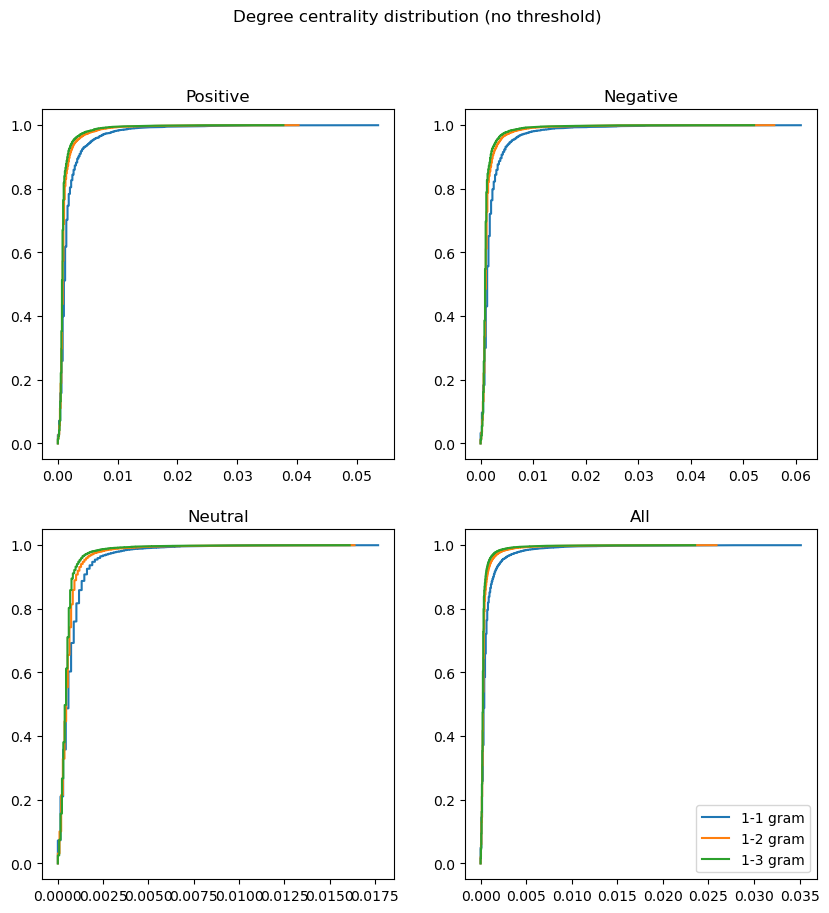

In [17]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_no_thresh_graphs, 'degree_centrality', axes[0,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Positive')
plot_graph_fun(neg_no_thresh_graphs, 'degree_centrality', axes[0,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Negative')
plot_graph_fun(neu_no_thresh_graphs, 'degree_centrality', axes[1,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Neutral')
plot_graph_fun(all_no_thresh_graphs, 'degree_centrality', axes[1,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'All')
axes[1,1].legend()
fig.suptitle('Degree centrality distribution (no threshold)')

Text(0.5, 0.98, 'Degree centrality distribution (low threshold)')

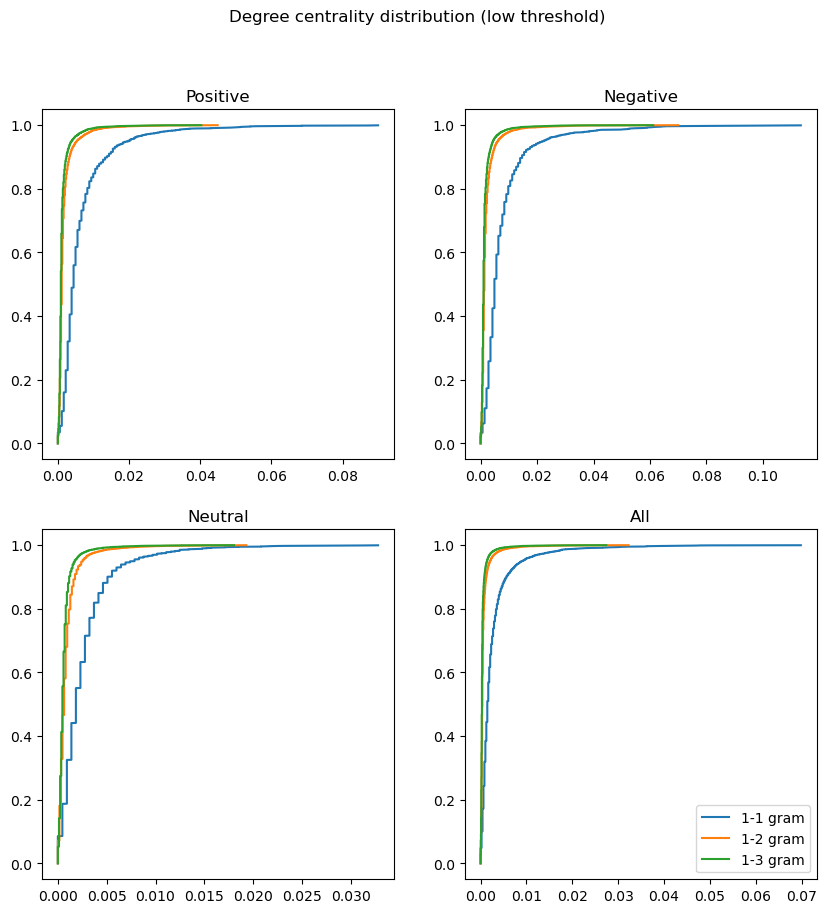

In [18]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_low_thresh_graphs, 'degree_centrality', axes[0,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Positive')
plot_graph_fun(neg_low_thresh_graphs, 'degree_centrality', axes[0,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Negative')
plot_graph_fun(neu_low_thresh_graphs, 'degree_centrality', axes[1,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Neutral')
plot_graph_fun(all_low_thresh_graphs, 'degree_centrality', axes[1,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'All')
axes[1,1].legend()
fig.suptitle('Degree centrality distribution (low threshold)')

Text(0.5, 0.98, 'Degree centrality distribution (high threshold)')

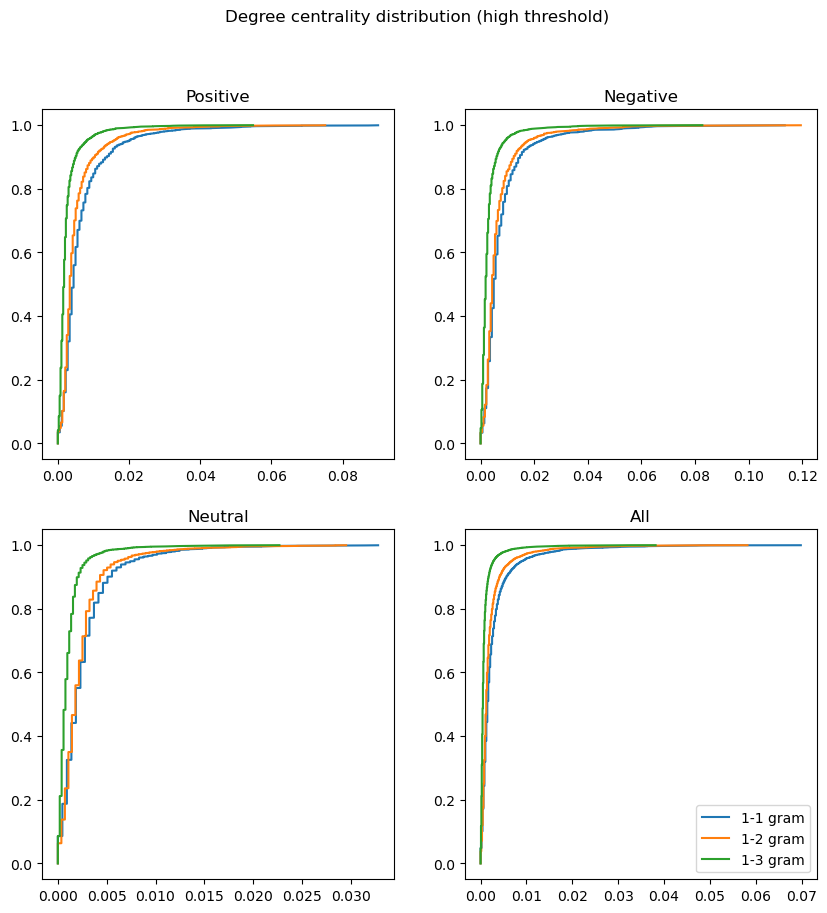

In [19]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_high_thresh_graphs, 'degree_centrality', axes[0,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Positive')
plot_graph_fun(neg_high_thresh_graphs, 'degree_centrality', axes[0,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Negative')
plot_graph_fun(neu_high_thresh_graphs, 'degree_centrality', axes[1,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Neutral')
plot_graph_fun(all_high_thresh_graphs, 'degree_centrality', axes[1,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'All')
axes[1,1].legend()
fig.suptitle('Degree centrality distribution (high threshold)')

Text(0.5, 0.98, 'Degree centrality distribution (all tweets)')

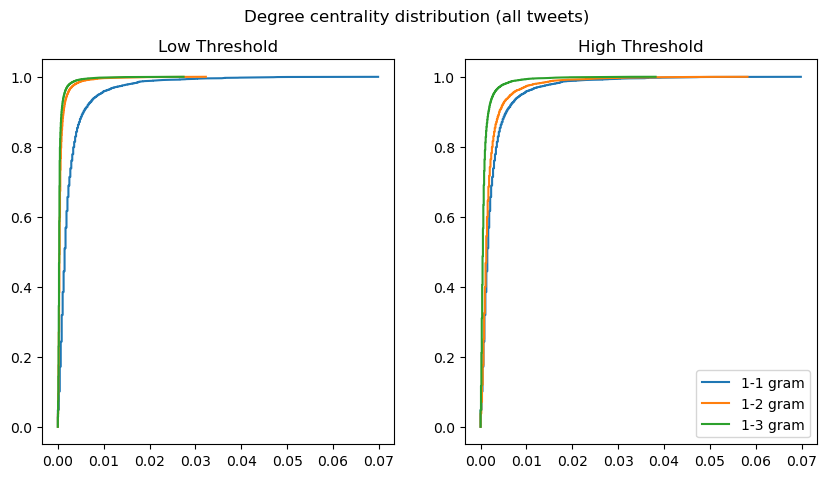

In [20]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

plot_graph_fun(all_low_thresh_graphs, 'degree_centrality', axes[0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
plot_graph_fun(all_high_thresh_graphs, 'degree_centrality', axes[1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')

axes[1].legend()
fig.suptitle('Degree centrality distribution (all tweets)')

In [21]:
def plot_graph_strength(graphs, axis, offset, labels, sentiment):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        fun_vals = sorted(list(dict(nx.degree(graph, weight = 'weight')).values()))[:-offset]
        cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)

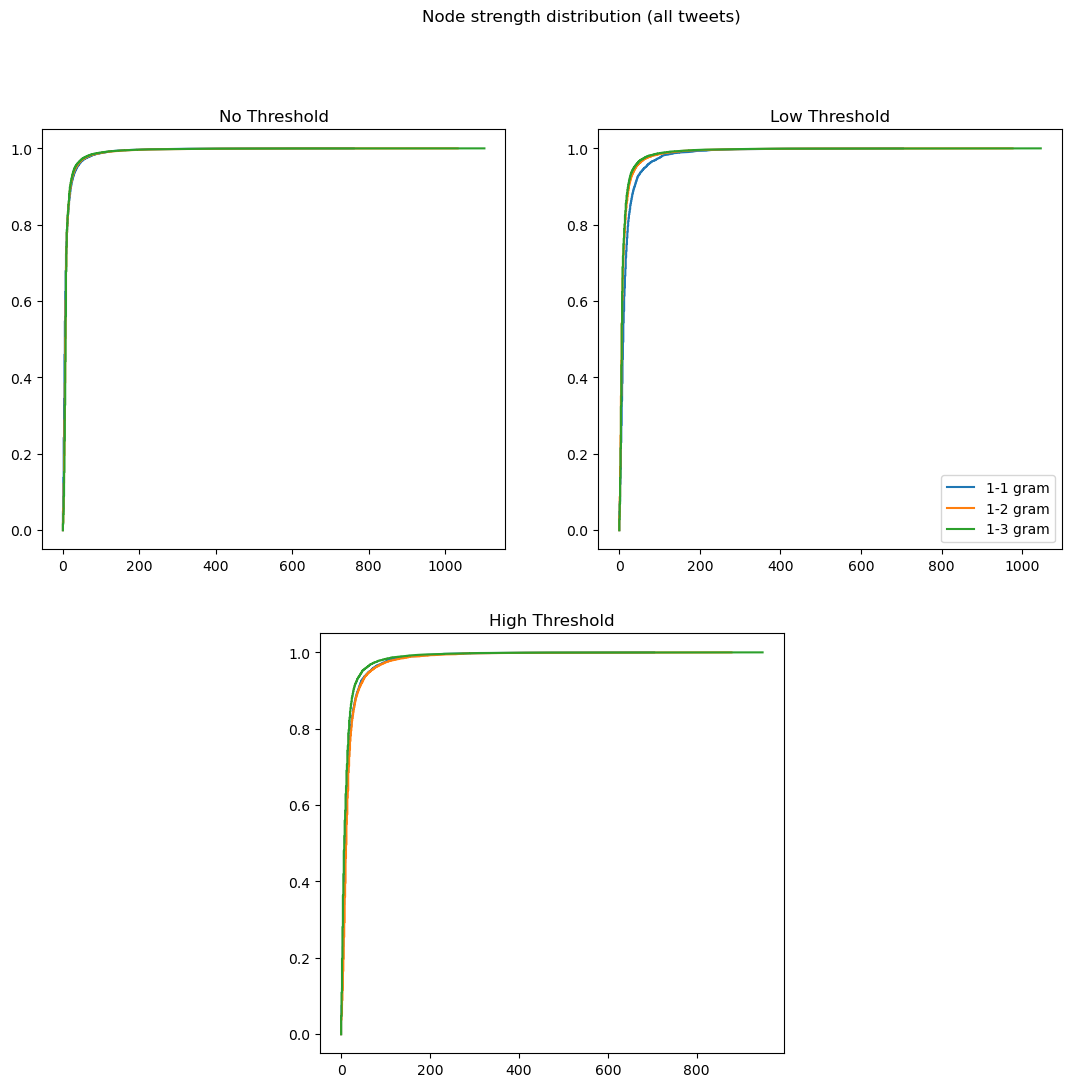

In [22]:
fig = plt.figure(constrained_layout=False, figsize=(12,12))
gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.05)
gs1.update(wspace=0.5)

ax1 = plt.subplot(gs1[0, :2], )

plot_graph_strength(all_no_thresh_graphs, ax1, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'No Threshold')
ax1.set_title('No Threshold')


ax2 = plt.subplot(gs1[0, 2:])

plot_graph_strength(all_low_thresh_graphs, ax2, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
ax2.set_title('Low Threshold')


ax3 = plt.subplot(gs1[1, 1:3])

plot_graph_strength(all_high_thresh_graphs, ax3, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')
ax3.set_title('High Threshold')

ax2.legend()
fig.suptitle('Node strength distribution (all tweets)')
plt.show()

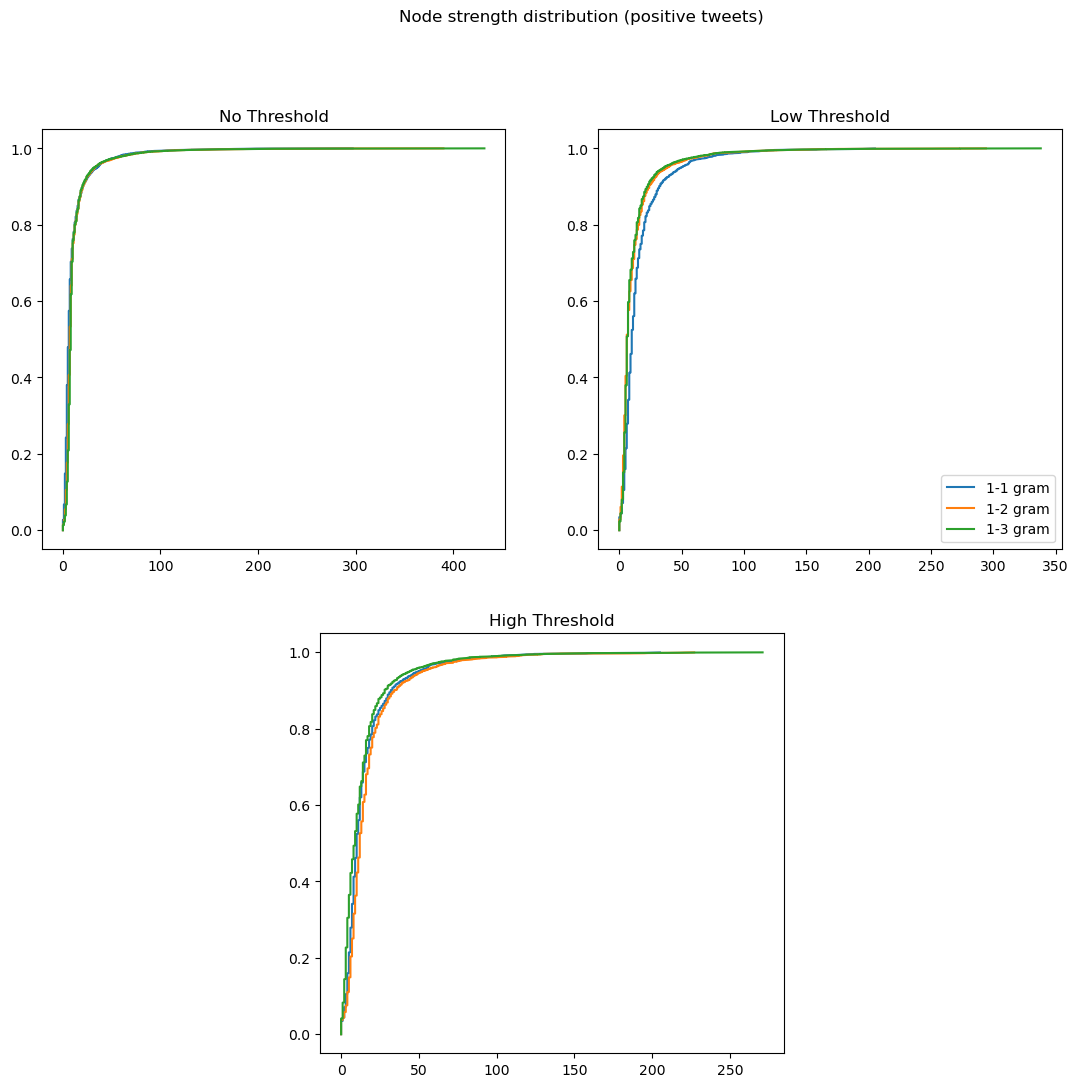

In [23]:
fig = plt.figure(constrained_layout=False, figsize=(12,12))
gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.05)
gs1.update(wspace=0.5)

ax1 = plt.subplot(gs1[0, :2], )

plot_graph_strength(pos_no_thresh_graphs, ax1, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'No Threshold')
ax1.set_title('No Threshold')


ax2 = plt.subplot(gs1[0, 2:])

plot_graph_strength(pos_low_thresh_graphs, ax2, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
ax2.set_title('Low Threshold')


ax3 = plt.subplot(gs1[1, 1:3])

plot_graph_strength(pos_high_thresh_graphs, ax3, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')
ax3.set_title('High Threshold')


ax2.legend()
fig.suptitle('Node strength distribution (positive tweets)')
plt.show()

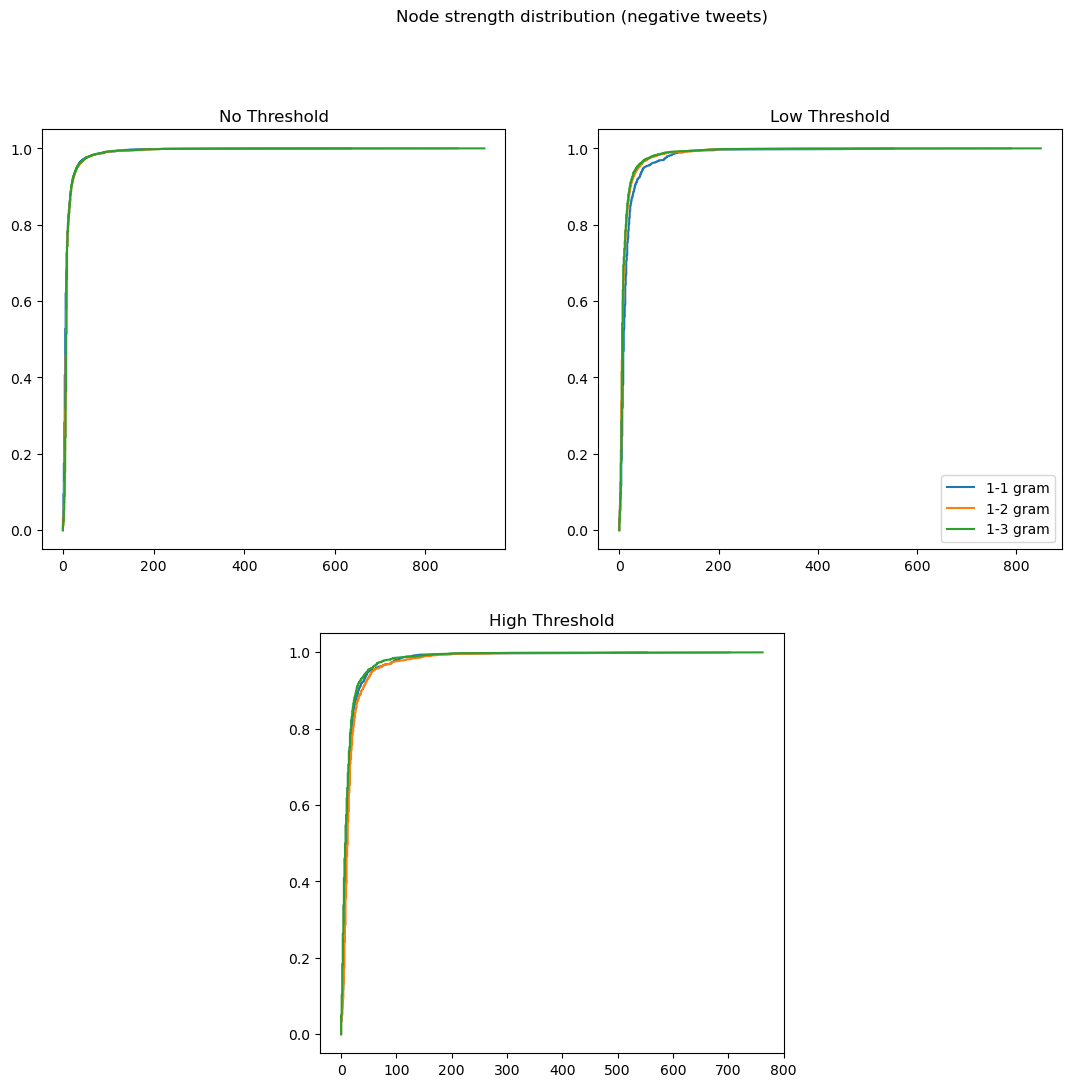

In [24]:
fig = plt.figure(constrained_layout=False, figsize=(12,12))
gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.05)
gs1.update(wspace=0.5)

ax1 = plt.subplot(gs1[0, :2], )

plot_graph_strength(neg_no_thresh_graphs, ax1, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'No Threshold')
ax1.set_title('No Threshold')


ax2 = plt.subplot(gs1[0, 2:])

plot_graph_strength(neg_low_thresh_graphs, ax2, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
ax2.set_title('Low Threshold')


ax3 = plt.subplot(gs1[1, 1:3])

plot_graph_strength(neg_high_thresh_graphs, ax3, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')
ax3.set_title('High Threshold')


ax2.legend()
fig.suptitle('Node strength distribution (negative tweets)')
plt.show()

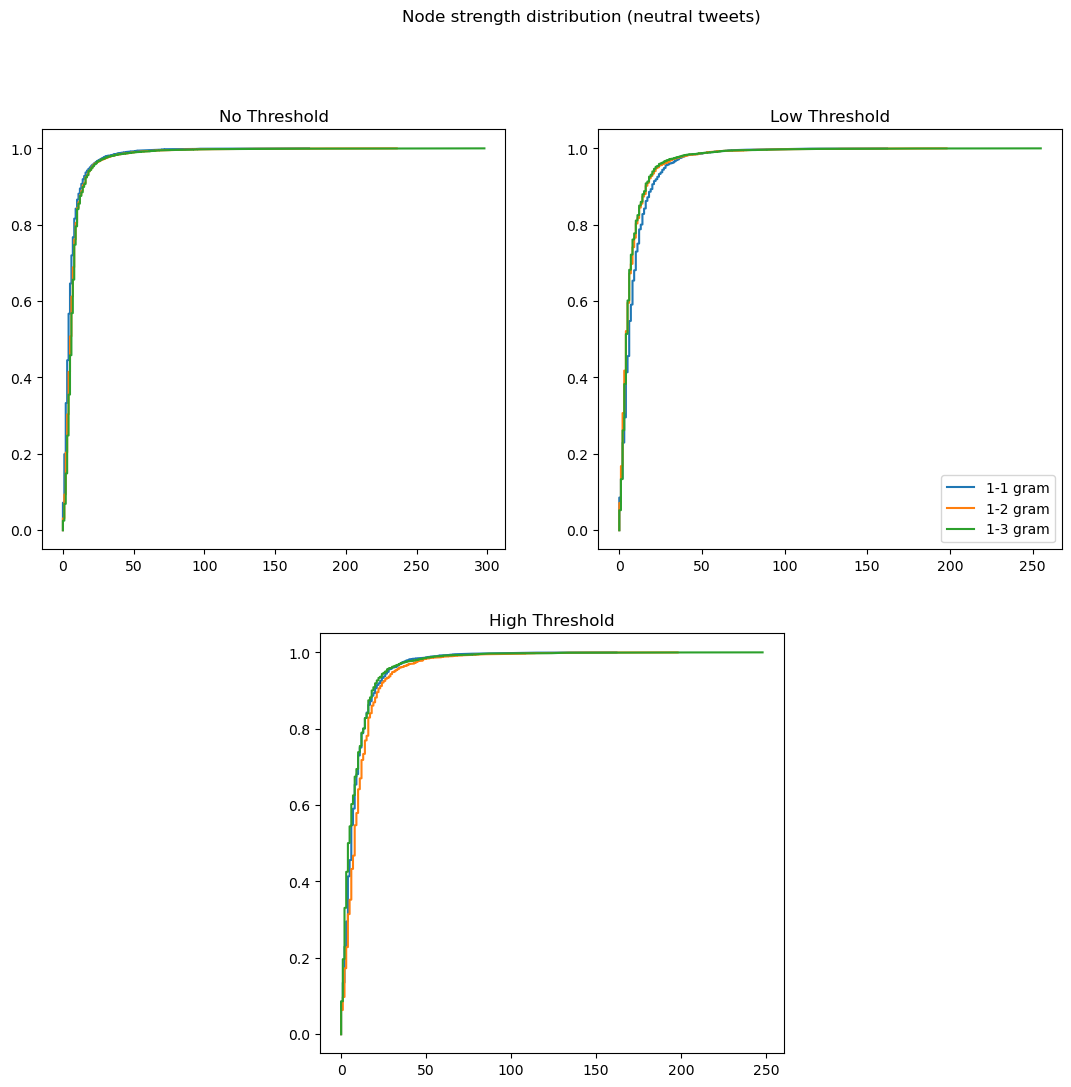

In [25]:
fig = plt.figure(constrained_layout=False, figsize=(12,12))
gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.05)
gs1.update(wspace=0.5)

ax1 = plt.subplot(gs1[0, :2], )

plot_graph_strength(neu_no_thresh_graphs, ax1, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'No Threshold')
ax1.set_title('No Threshold')


ax2 = plt.subplot(gs1[0, 2:])

plot_graph_strength(neu_low_thresh_graphs, ax2, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
ax2.set_title('Low Threshold')


ax3 = plt.subplot(gs1[1, 1:3])

plot_graph_strength(neu_high_thresh_graphs, ax3, 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')
ax3.set_title('High Threshold')


ax2.legend()
fig.suptitle('Node strength distribution (neutral tweets)')
plt.show()

#### Node Assortivity

We can also calculate network assortivity values, to see how nodes tend to connect to each other based on their strength, degree, or count.

In [26]:
def generate_network_assort_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'strength', 'degree', 'count'])
    for setup in graphs:
        graph = graphs[setup]
        strength = nx.degree_assortativity_coefficient(graph, weight = 'weight')
        degree_coeff = nx.degree_assortativity_coefficient(graph)
        count_coeff = nx.attribute_assortativity_coefficient(graph, 'count')
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'strength': [strength], 'degree': [degree_coeff]
                                            ,'count': [count_coeff]})], ignore_index = True)
        
    return network_prop_df

For all 1-1, 1-2, 1-3 graphs, the assortivity values are low, and do not offer much insight.

In [27]:
generate_network_assort_table(thresh_graphs)

,setup,strength,degree,count
0,graph_pos_11_2,-0.038626,-0.028844,0.008093
1,graph_neg_11_2,-0.028913,-0.032664,0.012256
2,graph_neu_11_2,0.017027,0.088768,0.036793
3,graph_all_11_2,-0.018607,-0.006406,0.012591
4,graph_pos_12_2,-0.020410,-0.018005,0.038512
5,graph_neg_12_2,-0.027291,-0.031947,0.042467
6,graph_neu_12_2,0.009012,0.017662,0.083819
7,graph_all_12_2,-0.019712,-0.016889,0.032185
8,graph_pos_13_2,-0.013913,-0.012635,0.056331
9,graph_neg_13_2,-0.022713,-0.026693,0.057680


## Node ranking

For each graph, we can rank nodes based on their degree or node centralities.

In [28]:
# the function ranks nodes in multiple graphs at once
# since graphs can have different numbers of nodes, we can limit how many of the top nodes are retained
def sorted_cent(graphs, topN):
    degCent_df = pd.DataFrame()
    nodeStr_df = pd.DataFrame()
    
    for setup in graphs:
        
        graph = graphs[setup]

        degCent = nx.degree_centrality(graph)
        degCent_sorted=dict(sorted(degCent.items(), key=lambda item: item[1],reverse=True))
        
        degCent_df[setup] = list(degCent_sorted.keys())[0:topN]
        
        nodeStr = nx.degree(graph, weight = 'weight')
        nodeStr_sorted = dict(sorted(dict(nodeStr).items(), key=lambda item: item[1],reverse=True))
        
        nodeStr_df[setup] = list(nodeStr_sorted.keys())[0:topN]
        
    return degCent_df, nodeStr_df

In [29]:
all_shortkey_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if '11' in key or '12' in key or '13' in key]}

In [30]:
degCent_rank_df, nodeStr_rank_df = sorted_cent(all_shortkey_graphs, 1400)

Rank-based overlap (RBO) shows how similar two ranked lists are. The p value dictates how much weight is given to comparisons of higher ranked nodes. The weightage calculator calculates what percentage of the score comes from the first d elements in the lists.

In [31]:
def rbo(S,T, p= 0.9):
    """ Takes two lists S and T of any lengths and gives out the RBO Score
    Parameters
    ----------
    S, T : Lists (str, integers)
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1. Default 0.9 give the top 10 
        elements 86% of the contribution in the final score.
    
    Returns
    -------
    Float of RBO score
    """
    
    # Fixed Terms
    k = max(len(S), len(T))
    x_k = len(set(S).intersection(set(T)))
    
    summation_term = 0

    # Loop for summation
    # k+1 for the loop to reach the last element (at k) in the bigger list    
    for d in range (1, k+1): 
            # Create sets from the lists
            set1 = set(S[:d]) if d < len(S) else set(S)
            set2 = set(T[:d]) if d < len(T) else set(T)
            
            # Intersection at depth d
            x_d = len(set1.intersection(set2))

            # Agreement at depth d
            a_d = x_d/d   
            
            # Summation
            summation_term = summation_term + math.pow(p, d) * a_d

    # Rank Biased Overlap - extrapolated
    rbo_ext = (x_k/k) * math.pow(p, k) + ((1-p)/p * summation_term)

    return rbo_ext

def weightage_calculator(p,d):
    """ Takes values of p and d
    ----------
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1.
    d : depth at which the weight has to be calculated
    
    Returns
    -------
    Float of Weightage Wrbo at depth d
    """

    summation_term = 0

    for i in range (1, d): # taking d here will loop upto the value d-1 
        summation_term = summation_term + math.pow(p,i)/i


    Wrbo_1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - summation_term))

    return Wrbo_1_d

For a p value of 0.9, the top 13 nodes count for ~90% of the score; for a 0.99 p value, the top 130 count for ~90% of the score.

In [32]:
print(weightage_calculator(0.9, 13))
print(weightage_calculator(0.99, 130))

0.9079099164989892
0.9039562429806366


We calculate rank based overlap of networks created with all, positive, negative, and neutral tweets. We calculate these values for p values of 0.9 and 0.99. 

#### Node Strength Rankings

###### All Tweets

In [33]:
all_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'all' in x]]

In [34]:
nodeStr_shortlist_all_df = pd.DataFrame(columns = all_nodeStr_rank_df.columns, index = all_nodeStr_rank_df.columns)

for col1 in all_nodeStr_rank_df:
    for col2 in all_nodeStr_rank_df:
        nodeStr_shortlist_all_df[col1][col2] = rbo(all_nodeStr_rank_df[col1],all_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_all_df = nodeStr_shortlist_all_df.astype(float)

nodeStr_longlist_all_df = pd.DataFrame(columns = all_nodeStr_rank_df.columns, index = all_nodeStr_rank_df.columns)

for col1 in all_nodeStr_rank_df:
    for col2 in all_nodeStr_rank_df:
        nodeStr_longlist_all_df[col1][col2] = rbo(all_nodeStr_rank_df[col1],all_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_all_df = nodeStr_longlist_all_df.astype(float)

In [35]:
nodeStr_shortlist_all_df.round(3)

,graph_all_11_1,graph_all_12_1,graph_all_13_1,graph_all_11_2,graph_all_12_2,graph_all_13_2,graph_all_11_5,graph_all_12_5,graph_all_13_5
graph_all_11_1,1.000,0.957,0.938,0.964,0.943,0.927,0.964,0.922,0.903
graph_all_12_1,0.957,1.000,0.963,0.952,0.957,0.961,0.952,0.938,0.936
graph_all_13_1,0.938,0.963,1.000,0.934,0.937,0.951,0.934,0.913,0.920
graph_all_11_2,0.964,0.952,0.934,1.000,0.962,0.939,1.000,0.953,0.931
graph_all_12_2,0.943,0.957,0.937,0.962,1.000,0.959,0.962,0.971,0.957
graph_all_13_2,0.927,0.961,0.951,0.939,0.959,1.000,0.939,0.940,0.956
graph_all_11_5,0.964,0.952,0.934,1.000,0.962,0.939,1.000,0.953,0.931
graph_all_12_5,0.922,0.938,0.913,0.953,0.971,0.940,0.953,1.000,0.970
graph_all_13_5,0.903,0.936,0.920,0.931,0.957,0.956,0.931,0.970,1.000


In [36]:
nodeStr_longlist_all_df.round(3)

,graph_all_11_1,graph_all_12_1,graph_all_13_1,graph_all_11_2,graph_all_12_2,graph_all_13_2,graph_all_11_5,graph_all_12_5,graph_all_13_5
graph_all_11_1,1.000,0.879,0.871,0.939,0.874,0.866,0.939,0.843,0.838
graph_all_12_1,0.879,1.000,0.966,0.866,0.952,0.956,0.866,0.900,0.915
graph_all_13_1,0.871,0.966,1.000,0.856,0.936,0.954,0.856,0.884,0.907
graph_all_11_2,0.939,0.866,0.856,1.000,0.882,0.871,1.000,0.870,0.861
graph_all_12_2,0.874,0.952,0.936,0.882,1.000,0.962,0.882,0.937,0.942
graph_all_13_2,0.866,0.956,0.954,0.871,0.962,1.000,0.871,0.918,0.942
graph_all_11_5,0.939,0.866,0.856,1.000,0.882,0.871,1.000,0.870,0.861
graph_all_12_5,0.843,0.900,0.884,0.870,0.937,0.918,0.870,1.000,0.956
graph_all_13_5,0.838,0.915,0.907,0.861,0.942,0.942,0.861,0.956,1.000


###### Positive Tweets

In [37]:
pos_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'pos' in x]]

In [38]:
nodeStr_shortlist_pos_df = pd.DataFrame(columns = pos_nodeStr_rank_df.columns, index = pos_nodeStr_rank_df.columns)

for col1 in pos_nodeStr_rank_df:
    for col2 in pos_nodeStr_rank_df:
        nodeStr_shortlist_pos_df[col1][col2] = rbo(pos_nodeStr_rank_df[col1],pos_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_pos_df = nodeStr_shortlist_pos_df.astype(float)

nodeStr_longlist_pos_df = pd.DataFrame(columns = pos_nodeStr_rank_df.columns, index = pos_nodeStr_rank_df.columns)

for col1 in pos_nodeStr_rank_df:
    for col2 in pos_nodeStr_rank_df:
        nodeStr_longlist_pos_df[col1][col2] = rbo(pos_nodeStr_rank_df[col1],pos_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_pos_df = nodeStr_longlist_pos_df.astype(float)

In [39]:
nodeStr_shortlist_pos_df.round(3)

,graph_pos_11_1,graph_pos_12_1,graph_pos_13_1,graph_pos_11_2,graph_pos_12_2,graph_pos_13_2,graph_pos_11_5,graph_pos_12_5,graph_pos_13_5
graph_pos_11_1,1.000,0.953,0.949,0.892,0.905,0.906,0.892,0.887,0.859
graph_pos_12_1,0.953,1.000,0.956,0.850,0.937,0.909,0.850,0.890,0.878
graph_pos_13_1,0.949,0.956,1.000,0.859,0.910,0.928,0.859,0.863,0.860
graph_pos_11_2,0.892,0.850,0.859,1.000,0.901,0.905,1.000,0.905,0.875
graph_pos_12_2,0.905,0.937,0.910,0.901,1.000,0.967,0.901,0.950,0.937
graph_pos_13_2,0.906,0.909,0.928,0.905,0.967,1.000,0.905,0.930,0.929
graph_pos_11_5,0.892,0.850,0.859,1.000,0.901,0.905,1.000,0.905,0.875
graph_pos_12_5,0.887,0.890,0.863,0.905,0.950,0.930,0.905,1.000,0.959
graph_pos_13_5,0.859,0.878,0.860,0.875,0.937,0.929,0.875,0.959,1.000


In [40]:
nodeStr_longlist_pos_df.round(3)

,graph_pos_11_1,graph_pos_12_1,graph_pos_13_1,graph_pos_11_2,graph_pos_12_2,graph_pos_13_2,graph_pos_11_5,graph_pos_12_5,graph_pos_13_5
graph_pos_11_1,1.000,0.900,0.889,0.901,0.880,0.871,0.901,0.832,0.830
graph_pos_12_1,0.900,1.000,0.960,0.843,0.933,0.927,0.843,0.855,0.862
graph_pos_13_1,0.889,0.960,1.000,0.837,0.918,0.938,0.837,0.843,0.867
graph_pos_11_2,0.901,0.843,0.837,1.000,0.877,0.863,1.000,0.882,0.867
graph_pos_12_2,0.880,0.933,0.918,0.877,1.000,0.955,0.877,0.907,0.909
graph_pos_13_2,0.871,0.927,0.938,0.863,0.955,1.000,0.863,0.888,0.916
graph_pos_11_5,0.901,0.843,0.837,1.000,0.877,0.863,1.000,0.882,0.867
graph_pos_12_5,0.832,0.855,0.843,0.882,0.907,0.888,0.882,1.000,0.944
graph_pos_13_5,0.830,0.862,0.867,0.867,0.909,0.916,0.867,0.944,1.000


###### Negative Tweets

In [41]:
neg_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'neg' in x]]

In [42]:
nodeStr_shortlist_neg_df = pd.DataFrame(columns = neg_nodeStr_rank_df.columns, index = neg_nodeStr_rank_df.columns)

for col1 in neg_nodeStr_rank_df:
    for col2 in neg_nodeStr_rank_df:
        nodeStr_shortlist_neg_df[col1][col2] = rbo(neg_nodeStr_rank_df[col1],neg_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_neg_df = nodeStr_shortlist_neg_df.astype(float)

nodeStr_longlist_neg_df = pd.DataFrame(columns = neg_nodeStr_rank_df.columns, index = neg_nodeStr_rank_df.columns)

for col1 in neg_nodeStr_rank_df:
    for col2 in neg_nodeStr_rank_df:
        nodeStr_longlist_neg_df[col1][col2] = rbo(neg_nodeStr_rank_df[col1],neg_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_neg_df = nodeStr_longlist_neg_df.astype(float)

In [43]:
nodeStr_shortlist_neg_df.round(3)

,graph_neg_11_1,graph_neg_12_1,graph_neg_13_1,graph_neg_11_2,graph_neg_12_2,graph_neg_13_2,graph_neg_11_5,graph_neg_12_5,graph_neg_13_5
graph_neg_11_1,1.000,0.937,0.947,0.939,0.913,0.928,0.939,0.876,0.899
graph_neg_12_1,0.937,1.000,0.976,0.934,0.964,0.971,0.934,0.918,0.945
graph_neg_13_1,0.947,0.976,1.000,0.928,0.948,0.967,0.928,0.902,0.930
graph_neg_11_2,0.939,0.934,0.928,1.000,0.930,0.936,1.000,0.899,0.924
graph_neg_12_2,0.913,0.964,0.948,0.930,1.000,0.973,0.930,0.951,0.973
graph_neg_13_2,0.928,0.971,0.967,0.936,0.973,1.000,0.936,0.931,0.957
graph_neg_11_5,0.939,0.934,0.928,1.000,0.930,0.936,1.000,0.899,0.924
graph_neg_12_5,0.876,0.918,0.902,0.899,0.951,0.931,0.899,1.000,0.965
graph_neg_13_5,0.899,0.945,0.930,0.924,0.973,0.957,0.924,0.965,1.000


In [44]:
nodeStr_longlist_neg_df.round(3)

,graph_neg_11_1,graph_neg_12_1,graph_neg_13_1,graph_neg_11_2,graph_neg_12_2,graph_neg_13_2,graph_neg_11_5,graph_neg_12_5,graph_neg_13_5
graph_neg_11_1,1.000,0.854,0.844,0.919,0.827,0.825,0.919,0.792,0.791
graph_neg_12_1,0.854,1.000,0.958,0.833,0.937,0.943,0.833,0.871,0.885
graph_neg_13_1,0.844,0.958,1.000,0.815,0.914,0.944,0.815,0.849,0.877
graph_neg_11_2,0.919,0.833,0.815,1.000,0.839,0.827,1.000,0.819,0.814
graph_neg_12_2,0.827,0.937,0.914,0.839,1.000,0.949,0.839,0.923,0.932
graph_neg_13_2,0.825,0.943,0.944,0.827,0.949,1.000,0.827,0.892,0.923
graph_neg_11_5,0.919,0.833,0.815,1.000,0.839,0.827,1.000,0.819,0.814
graph_neg_12_5,0.792,0.871,0.849,0.819,0.923,0.892,0.819,1.000,0.943
graph_neg_13_5,0.791,0.885,0.877,0.814,0.932,0.923,0.814,0.943,1.000


###### Neutral Tweets

In [45]:
neu_nodeStr_rank_df = nodeStr_rank_df[[x for x in list(nodeStr_rank_df.columns) if 'neu' in x]]

In [46]:
nodeStr_shortlist_neu_df = pd.DataFrame(columns = neu_nodeStr_rank_df.columns, index = neu_nodeStr_rank_df.columns)

for col1 in neu_nodeStr_rank_df:
    for col2 in neu_nodeStr_rank_df:
        nodeStr_shortlist_neu_df[col1][col2] = rbo(neu_nodeStr_rank_df[col1],neu_nodeStr_rank_df[col2], p = 0.9)
        
nodeStr_shortlist_neu_df = nodeStr_shortlist_neu_df.astype(float)

nodeStr_longlist_neu_df = pd.DataFrame(columns = neu_nodeStr_rank_df.columns, index = neu_nodeStr_rank_df.columns)

for col1 in neu_nodeStr_rank_df:
    for col2 in neu_nodeStr_rank_df:
        nodeStr_longlist_neu_df[col1][col2] = rbo(neu_nodeStr_rank_df[col1],neu_nodeStr_rank_df[col2], p = 0.99)
        
nodeStr_longlist_neu_df = nodeStr_longlist_neu_df.astype(float)

In [49]:
nodeStr_shortlist_neu_df.round(3)

,graph_neu_11_1,graph_neu_12_1,graph_neu_13_1,graph_neu_11_2,graph_neu_12_2,graph_neu_13_2,graph_neu_11_5,graph_neu_12_5,graph_neu_13_5
graph_neu_11_1,1.000,0.535,0.532,0.813,0.664,0.631,0.813,0.648,0.654
graph_neu_12_1,0.535,1.000,0.941,0.516,0.723,0.781,0.516,0.648,0.672
graph_neu_13_1,0.532,0.941,1.000,0.515,0.738,0.804,0.515,0.660,0.691
graph_neu_11_2,0.813,0.516,0.515,1.000,0.733,0.643,1.000,0.746,0.739
graph_neu_12_2,0.664,0.723,0.738,0.733,1.000,0.895,0.733,0.904,0.929
graph_neu_13_2,0.631,0.781,0.804,0.643,0.895,1.000,0.643,0.806,0.860
graph_neu_11_5,0.813,0.516,0.515,1.000,0.733,0.643,1.000,0.746,0.739
graph_neu_12_5,0.648,0.648,0.660,0.746,0.904,0.806,0.746,1.000,0.930
graph_neu_13_5,0.654,0.672,0.691,0.739,0.929,0.860,0.739,0.930,1.000


In [50]:
nodeStr_longlist_neu_df.round(3)

,graph_neu_11_1,graph_neu_12_1,graph_neu_13_1,graph_neu_11_2,graph_neu_12_2,graph_neu_13_2,graph_neu_11_5,graph_neu_12_5,graph_neu_13_5
graph_neu_11_1,1.000,0.755,0.726,0.816,0.749,0.715,0.816,0.687,0.673
graph_neu_12_1,0.755,1.000,0.933,0.665,0.869,0.859,0.665,0.760,0.763
graph_neu_13_1,0.726,0.933,1.000,0.652,0.860,0.894,0.652,0.760,0.790
graph_neu_11_2,0.816,0.665,0.652,1.000,0.750,0.701,1.000,0.771,0.718
graph_neu_12_2,0.749,0.869,0.860,0.750,1.000,0.912,0.750,0.873,0.867
graph_neu_13_2,0.715,0.859,0.894,0.701,0.912,1.000,0.701,0.833,0.881
graph_neu_11_5,0.816,0.665,0.652,1.000,0.750,0.701,1.000,0.771,0.718
graph_neu_12_5,0.687,0.760,0.760,0.771,0.873,0.833,0.771,1.000,0.896
graph_neu_13_5,0.673,0.763,0.790,0.718,0.867,0.881,0.718,0.896,1.000


#### Degree Centrality Rankings

###### All Tweets

In [51]:
all_degCent_rank_df = degCent_rank_df[[x for x in list(degCent_rank_df.columns) if 'all' in x]]

In [52]:
degCent_shortlist_all_df = pd.DataFrame(columns = all_degCent_rank_df.columns, index = all_degCent_rank_df.columns)

for col1 in all_degCent_rank_df:
    for col2 in all_degCent_rank_df:
        degCent_shortlist_all_df[col1][col2] = rbo(all_degCent_rank_df[col1],all_degCent_rank_df[col2], p = 0.9)
        
degCent_shortlist_all_df = degCent_shortlist_all_df.astype(float)

degCent_longlist_all_df = pd.DataFrame(columns = all_degCent_rank_df.columns, index = all_degCent_rank_df.columns)

for col1 in all_degCent_rank_df:
    for col2 in all_degCent_rank_df:
        degCent_longlist_all_df[col1][col2] = rbo(all_degCent_rank_df[col1],all_degCent_rank_df[col2], p = 0.99)
        
degCent_longlist_all_df = degCent_longlist_all_df.astype(float)

In [59]:
degCent_shortlist_all_df

,graph_all_11_1,graph_all_12_1,graph_all_13_1,graph_all_11_2,graph_all_12_2,graph_all_13_2,graph_all_11_5,graph_all_12_5,graph_all_13_5
graph_all_11_1,1.000000,0.834604,0.821256,0.897564,0.855153,0.820783,0.897564,0.837596,0.801684
graph_all_12_1,0.834604,1.000000,0.958790,0.875427,0.907348,0.926164,0.875427,0.900670,0.908327
graph_all_13_1,0.821256,0.958790,1.000000,0.859403,0.908764,0.932373,0.859403,0.890927,0.914895
graph_all_11_2,0.897564,0.875427,0.859403,1.000000,0.928701,0.890475,1.000000,0.930227,0.883004
graph_all_12_2,0.855153,0.907348,0.908764,0.928701,1.000000,0.956531,0.928701,0.945659,0.937921
graph_all_13_2,0.820783,0.926164,0.932373,0.890475,0.956531,1.000000,0.890475,0.920958,0.960977
graph_all_11_5,0.897564,0.875427,0.859403,1.000000,0.928701,0.890475,1.000000,0.930227,0.883004
graph_all_12_5,0.837596,0.900670,0.890927,0.930227,0.945659,0.920958,0.930227,1.000000,0.942143
graph_all_13_5,0.801684,0.908327,0.914895,0.883004,0.937921,0.960977,0.883004,0.942143,1.000000


In [60]:
degCent_longlist_all_df

,graph_all_11_1,graph_all_12_1,graph_all_13_1,graph_all_11_2,graph_all_12_2,graph_all_13_2,graph_all_11_5,graph_all_12_5,graph_all_13_5
graph_all_11_1,1.000000,0.856417,0.843287,0.929856,0.857076,0.839740,0.929856,0.847691,0.831514
graph_all_12_1,0.856417,1.000000,0.969250,0.852466,0.945529,0.945887,0.852466,0.913141,0.923072
graph_all_13_1,0.843287,0.969250,1.000000,0.841065,0.937003,0.953875,0.841065,0.903941,0.928610
graph_all_11_2,0.929856,0.852466,0.841065,1.000000,0.876911,0.856565,1.000000,0.884849,0.859676
graph_all_12_2,0.857076,0.945529,0.937003,0.876911,1.000000,0.964397,0.876911,0.942860,0.943219
graph_all_13_2,0.839740,0.945887,0.953875,0.856565,0.964397,1.000000,0.856565,0.926029,0.955196
graph_all_11_5,0.929856,0.852466,0.841065,1.000000,0.876911,0.856565,1.000000,0.884849,0.859676
graph_all_12_5,0.847691,0.913141,0.903941,0.884849,0.942860,0.926029,0.884849,1.000000,0.951140
graph_all_13_5,0.831514,0.923072,0.928610,0.859676,0.943219,0.955196,0.859676,0.951140,1.000000


###### Positive Tweets

In [53]:
pos_degCent_rank_df = degCent_rank_df[[x for x in list(degCent_rank_df.columns) if 'pos' in x]]

In [54]:
degCent_shortlist_pos_df = pd.DataFrame(columns = pos_degCent_rank_df.columns, index = pos_degCent_rank_df.columns)

for col1 in pos_degCent_rank_df:
    for col2 in pos_degCent_rank_df:
        degCent_shortlist_pos_df[col1][col2] = rbo(pos_degCent_rank_df[col1],pos_degCent_rank_df[col2], p = 0.9)
        
degCent_shortlist_pos_df = degCent_shortlist_pos_df.astype(float)

degCent_longlist_pos_df = pd.DataFrame(columns = pos_degCent_rank_df.columns, index = pos_degCent_rank_df.columns)

for col1 in pos_degCent_rank_df:
    for col2 in pos_degCent_rank_df:
        degCent_longlist_pos_df[col1][col2] = rbo(pos_degCent_rank_df[col1],pos_degCent_rank_df[col2], p = 0.99)
        
degCent_longlist_pos_df = degCent_longlist_pos_df.astype(float)

In [61]:
degCent_shortlist_pos_df

,graph_pos_11_1,graph_pos_12_1,graph_pos_13_1,graph_pos_11_2,graph_pos_12_2,graph_pos_13_2,graph_pos_11_5,graph_pos_12_5,graph_pos_13_5
graph_pos_11_1,1.000000,0.953968,0.925872,0.927563,0.941143,0.922666,0.927563,0.899797,0.868235
graph_pos_12_1,0.953968,1.000000,0.950022,0.888716,0.941589,0.952037,0.888716,0.901941,0.871471
graph_pos_13_1,0.925872,0.950022,1.000000,0.897104,0.948233,0.976557,0.897104,0.897793,0.877122
graph_pos_11_2,0.927563,0.888716,0.897104,1.000000,0.924107,0.897272,1.000000,0.932008,0.882394
graph_pos_12_2,0.941143,0.941589,0.948233,0.924107,1.000000,0.960510,0.924107,0.934556,0.892100
graph_pos_13_2,0.922666,0.952037,0.976557,0.897272,0.960510,1.000000,0.897272,0.909452,0.889204
graph_pos_11_5,0.927563,0.888716,0.897104,1.000000,0.924107,0.897272,1.000000,0.932008,0.882394
graph_pos_12_5,0.899797,0.901941,0.897793,0.932008,0.934556,0.909452,0.932008,1.000000,0.912635
graph_pos_13_5,0.868235,0.871471,0.877122,0.882394,0.892100,0.889204,0.882394,0.912635,1.000000


In [62]:
degCent_longlist_pos_df

,graph_pos_11_1,graph_pos_12_1,graph_pos_13_1,graph_pos_11_2,graph_pos_12_2,graph_pos_13_2,graph_pos_11_5,graph_pos_12_5,graph_pos_13_5
graph_pos_11_1,1.000000,0.902614,0.886877,0.917735,0.880354,0.867529,0.917735,0.860749,0.853712
graph_pos_12_1,0.902614,1.000000,0.960829,0.866386,0.937516,0.933508,0.866386,0.891619,0.893925
graph_pos_13_1,0.886877,0.960829,1.000000,0.858519,0.929930,0.948665,0.858519,0.882488,0.902907
graph_pos_11_2,0.917735,0.866386,0.858519,1.000000,0.887162,0.866708,1.000000,0.898543,0.875573
graph_pos_12_2,0.880354,0.937516,0.929930,0.887162,1.000000,0.955190,0.887162,0.919289,0.912892
graph_pos_13_2,0.867529,0.933508,0.948665,0.866708,0.955190,1.000000,0.866708,0.903385,0.925219
graph_pos_11_5,0.917735,0.866386,0.858519,1.000000,0.887162,0.866708,1.000000,0.898543,0.875573
graph_pos_12_5,0.860749,0.891619,0.882488,0.898543,0.919289,0.903385,0.898543,1.000000,0.938104
graph_pos_13_5,0.853712,0.893925,0.902907,0.875573,0.912892,0.925219,0.875573,0.938104,1.000000


###### Negative Tweets

In [55]:
neg_degCent_rank_df = degCent_rank_df[[x for x in list(degCent_rank_df.columns) if 'neg' in x]]

In [56]:
degCent_shortlist_neg_df = pd.DataFrame(columns = neg_degCent_rank_df.columns, index = neg_degCent_rank_df.columns)

for col1 in neg_degCent_rank_df:
    for col2 in neg_degCent_rank_df:
        degCent_shortlist_neg_df[col1][col2] = rbo(neg_degCent_rank_df[col1],neg_degCent_rank_df[col2], p = 0.9)
        
degCent_shortlist_neg_df = degCent_shortlist_neg_df.astype(float)

degCent_longlist_neg_df = pd.DataFrame(columns = neg_degCent_rank_df.columns, index = neg_degCent_rank_df.columns)

for col1 in neg_degCent_rank_df:
    for col2 in neg_degCent_rank_df:
        degCent_longlist_neg_df[col1][col2] = rbo(neg_degCent_rank_df[col1],neg_degCent_rank_df[col2], p = 0.99)
        
degCent_longlist_neg_df = degCent_longlist_neg_df.astype(float)

In [63]:
degCent_shortlist_neg_df

,graph_neg_11_1,graph_neg_12_1,graph_neg_13_1,graph_neg_11_2,graph_neg_12_2,graph_neg_13_2,graph_neg_11_5,graph_neg_12_5,graph_neg_13_5
graph_neg_11_1,1.000000,0.921027,0.914196,0.959349,0.906178,0.901896,0.959349,0.901275,0.911516
graph_neg_12_1,0.921027,1.000000,0.985556,0.927168,0.964398,0.964879,0.927168,0.942806,0.950044
graph_neg_13_1,0.914196,0.985556,1.000000,0.923254,0.957351,0.969552,0.923254,0.940124,0.956562
graph_neg_11_2,0.959349,0.927168,0.923254,1.000000,0.927182,0.919358,1.000000,0.926734,0.930398
graph_neg_12_2,0.906178,0.964398,0.957351,0.927182,1.000000,0.979286,0.927182,0.952027,0.949120
graph_neg_13_2,0.901896,0.964879,0.969552,0.919358,0.979286,1.000000,0.919358,0.950190,0.957508
graph_neg_11_5,0.959349,0.927168,0.923254,1.000000,0.927182,0.919358,1.000000,0.926734,0.930398
graph_neg_12_5,0.901275,0.942806,0.940124,0.926734,0.952027,0.950190,0.926734,1.000000,0.970403
graph_neg_13_5,0.911516,0.950044,0.956562,0.930398,0.949120,0.957508,0.930398,0.970403,1.000000


In [64]:
degCent_longlist_neg_df

,graph_neg_11_1,graph_neg_12_1,graph_neg_13_1,graph_neg_11_2,graph_neg_12_2,graph_neg_13_2,graph_neg_11_5,graph_neg_12_5,graph_neg_13_5
graph_neg_11_1,1.000000,0.875471,0.862548,0.919980,0.846613,0.838139,0.919980,0.840030,0.841531
graph_neg_12_1,0.875471,1.000000,0.964188,0.855467,0.938207,0.933415,0.855467,0.892587,0.899787
graph_neg_13_1,0.862548,0.964188,1.000000,0.844000,0.926475,0.946323,0.844000,0.880424,0.909033
graph_neg_11_2,0.919980,0.855467,0.844000,1.000000,0.865306,0.851887,1.000000,0.875018,0.864474
graph_neg_12_2,0.846613,0.938207,0.926475,0.865306,1.000000,0.958113,0.865306,0.920994,0.919572
graph_neg_13_2,0.838139,0.933415,0.946323,0.851887,0.958113,1.000000,0.851887,0.903500,0.930041
graph_neg_11_5,0.919980,0.855467,0.844000,1.000000,0.865306,0.851887,1.000000,0.875018,0.864474
graph_neg_12_5,0.840030,0.892587,0.880424,0.875018,0.920994,0.903500,0.875018,1.000000,0.943304
graph_neg_13_5,0.841531,0.899787,0.909033,0.864474,0.919572,0.930041,0.864474,0.943304,1.000000


###### Neutral Tweets

In [57]:
neu_degCent_rank_df = degCent_rank_df[[x for x in list(degCent_rank_df.columns) if 'neu' in x]]

In [58]:
degCent_shortlist_neu_df = pd.DataFrame(columns = neu_degCent_rank_df.columns, index = neu_degCent_rank_df.columns)

for col1 in neu_degCent_rank_df:
    for col2 in neu_degCent_rank_df:
        degCent_shortlist_neu_df[col1][col2] = rbo(neu_degCent_rank_df[col1],neu_degCent_rank_df[col2], p = 0.9)
        
degCent_shortlist_neu_df = degCent_shortlist_neu_df.astype(float)

degCent_longlist_neu_df = pd.DataFrame(columns = neu_degCent_rank_df.columns, index = neu_degCent_rank_df.columns)

for col1 in neu_degCent_rank_df:
    for col2 in neu_degCent_rank_df:
        degCent_longlist_neu_df[col1][col2] = rbo(neu_degCent_rank_df[col1],neu_degCent_rank_df[col2], p = 0.99)
        
degCent_longlist_neu_df = degCent_longlist_neu_df.astype(float)

In [65]:
degCent_shortlist_neu_df

,graph_neu_11_1,graph_neu_12_1,graph_neu_13_1,graph_neu_11_2,graph_neu_12_2,graph_neu_13_2,graph_neu_11_5,graph_neu_12_5,graph_neu_13_5
graph_neu_11_1,1.000000,0.387997,0.374821,0.705528,0.428291,0.406739,0.705528,0.452398,0.356441
graph_neu_12_1,0.387997,1.000000,0.950394,0.380371,0.902424,0.896299,0.380371,0.833975,0.869234
graph_neu_13_1,0.374821,0.950394,1.000000,0.373848,0.860853,0.921993,0.373848,0.800278,0.892985
graph_neu_11_2,0.705528,0.380371,0.373848,1.000000,0.431726,0.401006,1.000000,0.472868,0.366925
graph_neu_12_2,0.428291,0.902424,0.860853,0.431726,1.000000,0.891391,0.431726,0.889746,0.864008
graph_neu_13_2,0.406739,0.896299,0.921993,0.401006,0.891391,1.000000,0.401006,0.834828,0.929959
graph_neu_11_5,0.705528,0.380371,0.373848,1.000000,0.431726,0.401006,1.000000,0.472868,0.366925
graph_neu_12_5,0.452398,0.833975,0.800278,0.472868,0.889746,0.834828,0.472868,1.000000,0.845877
graph_neu_13_5,0.356441,0.869234,0.892985,0.366925,0.864008,0.929959,0.366925,0.845877,1.000000


In [66]:
degCent_longlist_neu_df

,graph_neu_11_1,graph_neu_12_1,graph_neu_13_1,graph_neu_11_2,graph_neu_12_2,graph_neu_13_2,graph_neu_11_5,graph_neu_12_5,graph_neu_13_5
graph_neu_11_1,1.000000,0.721887,0.688614,0.801549,0.699019,0.667182,0.801549,0.653343,0.621335
graph_neu_12_1,0.721887,1.000000,0.939269,0.651857,0.897033,0.881184,0.651857,0.800953,0.816266
graph_neu_13_1,0.688614,0.939269,1.000000,0.639077,0.876324,0.906762,0.639077,0.791369,0.840600
graph_neu_11_2,0.801549,0.651857,0.639077,1.000000,0.705251,0.667299,1.000000,0.733646,0.667119
graph_neu_12_2,0.699019,0.897033,0.876324,0.705251,1.000000,0.914816,0.705251,0.866196,0.858313
graph_neu_13_2,0.667182,0.881184,0.906762,0.667299,0.914816,1.000000,0.667299,0.840451,0.897066
graph_neu_11_5,0.801549,0.651857,0.639077,1.000000,0.705251,0.667299,1.000000,0.733646,0.667119
graph_neu_12_5,0.653343,0.800953,0.791369,0.733646,0.866196,0.840451,0.733646,1.000000,0.885979
graph_neu_13_5,0.621335,0.816266,0.840600,0.667119,0.858313,0.897066,0.667119,0.885979,1.000000
